In [5]:
!pip install torch
!pip install matplotlib
!pip install numpy
!pip install kagglehub

  Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_universal2.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached numpy-2.3.0-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pillow-11.2.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp313-cp313-macosx_10_13_universal2.whl (2.7 MB)
Using cached kiwisolver-1.4.8-cp313-cp313-macosx_11_0_arm64.whl (65 kB)
Using cached numpy-2

In [271]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import torch
import os
from torch.distributions import Categorical
%matplotlib inline

In [586]:
def download_dataset() -> str:
    path = kagglehub.dataset_download("rishitjakharia/names-txt")
    return path # for easier access later

In [587]:
dataset_path = download_dataset() + "/names.txt"

In [588]:
words = open(dataset_path, 'r').read().splitlines()

In [589]:
def make_int_char_maps() -> tuple[dict, dict]:
  chars = sorted(list(set(''.join(words))))
  ctoi = {c: i + 1 for i, c in enumerate(chars)}
  ctoi['.'] = 0
  itoc = {i: c for c, i in ctoi.items()}
  return ctoi, itoc

In [590]:
ctoi, itoc = make_int_char_maps()

In [591]:
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [592]:
print(ctoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [593]:
vocab_size = len(ctoi)
print(vocab_size)

27


In [746]:
block_size = 6
def build_dataset(inp_words) -> tuple[torch.tensor, torch.tensor]:
  inp, target = [], []
  for w in inp_words: 
    context = [0] * block_size

    for ch in w + '.':
      ix = ctoi[ch]
      inp.append(context)
      target.append(ix)
      context = context[1:] + [ix] # crop and append

  inp = torch.tensor(inp)
  target = torch.tensor(target)
  return inp, target

In [747]:
import random
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [748]:
Xtr.shape, Ytr.shape

(torch.Size([182614, 6]), torch.Size([182614]))

In [749]:
for x,y in zip(Xtr[:30], Ytr[:30]):
  print(''.join(itoc[ix.item()] for ix in x), '-->', itoc[y.item()])

...... --> k
.....k --> l
....kl --> o
...klo --> e
..kloe --> y
.kloey --> .
...... --> r
.....r --> o
....ro --> y
...roy --> a
..roya --> l
.royal --> l
royall --> e
oyalle --> .
...... --> s
.....s --> i
....si --> t
...sit --> o
..sito --> r
.sitor --> a
sitora --> .
...... --> s
.....s --> a
....sa --> a
...saa --> r
..saar --> t
.saart --> h
saarth --> .
...... --> k
.....k --> e


In [750]:
import torch.nn as nn

In [792]:
n_emb = 32 # dimensionality of the character vectors
n_hidden = 100 # num hidden layer neurons
num_layers = 1

In [793]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embd_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embd_size)  
        self.rnn = nn.LSTM(input_size=embd_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, input_seq, hidden_state=None):
        # input_seq: (seq_len, batch)
        embedding = self.embedding(input_seq)  
        output, hidden_state = self.rnn(embedding, hidden_state)
        out = self.decoder(output)  
        return out, (hidden_state[0].detach(), hidden_state[1].detach())

In [802]:
model = CharRNN(vocab_size, n_emb, n_hidden, num_layers)

# make the last layer less confident
with torch.no_grad():
    model.decoder.weight.mul(0.1)

params = model.parameters()
print(f"Num Params: {sum(p.nelement() for p in params)}")
for param in params:
    param.requires_grad = True


optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50_000, gamma=0.5) 


Num Params: 57191


In [803]:
print(model)

CharRNN(
  (embedding): Embedding(27, 32)
  (rnn): LSTM(32, 100, batch_first=True)
  (decoder): Linear(in_features=100, out_features=27, bias=True)
)


In [804]:
def sample_name(model, block_size, ctoi, itoc, device):
    model.eval()
    context = [ctoi['.']] * block_size
    name = ''
    hidden = None
    while True:
        x = torch.tensor([context], dtype=torch.long).to(device)
        logits, hidden = model(x, hidden)            # logits: (1, seq_len, vocab_size)
        logits = logits[:, -1, :]                    # take the output at the last timestep: (1, vocab_size)
        probs = F.softmax(logits, dim=-1)            # (1, vocab_size)
        dist = Categorical(probs)
        idx = dist.sample().item()
        char = itoc[idx]
        if char == '.':
            break
        name += char
        context = context[1:] + [idx]
    model.train()
    return name.capitalize()

In [805]:
lossi = []

def train(
    X, Y, model, epochs=10_000, batch_size=256, lr=0.01, device='mps'
):
    model = model.to(device)
    X, Y = X.to(device), Y.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(1, epochs+1):
        idxs = torch.randint(0, X.size(0), (batch_size,))
        xb, yb = X[idxs], Y[idxs]
        logits, _ = model(xb)
        logits = logits[:, -1, :]   # (batch, vocab_size), at last timestep
        loss = loss_fn(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        lossi.append(loss.item())

        if epoch % 1_000 == 0:
            print(f"Epoch {epoch} | Loss: {loss:.4f}")
            # Sample after each epoch
            print("-- Sampled names: --")
            for _ in range(5):
                print(sample_name(model, block_size, ctoi, itoc, device))
            print('-' * 30)

In [806]:
train(X=Xtr, Y=Ytr, model=model)

Epoch 1000 | Loss: 2.2123
-- Sampled names: --
Larrice
Rumelleeu
Jalasi
Jyar
Hannahlen
------------------------------
Epoch 2000 | Loss: 2.3107
-- Sampled names: --
Clyaliua
Gbraia
Jailiaher
Kallan
Ledtr
------------------------------
Epoch 3000 | Loss: 2.2952
-- Sampled names: --
Ghelanio
Disall
Ac
Mabziwa
Dakuynn
------------------------------
Epoch 4000 | Loss: 2.2710
-- Sampled names: --
Vandaya
Hamiya
Reilienie
Waylline
Mezeli
------------------------------
Epoch 5000 | Loss: 2.2507
-- Sampled names: --
Salieztery
Ahliallen
Jereme
Zadau
Deyah
------------------------------
Epoch 6000 | Loss: 2.2476
-- Sampled names: --
Latemi
Jatie
Zrrig
Asrteya
Arlelyn
------------------------------
Epoch 7000 | Loss: 2.3182
-- Sampled names: --
Kelico
Furiwer
Khronsue
Koraze
Kdemuen
------------------------------
Epoch 8000 | Loss: 2.4159
-- Sampled names: --
Wabtitux
Gelson
Jahlish
Hearas
Carlyan
------------------------------
Epoch 9000 | Loss: 2.2917
-- Sampled names: --
Atnoe
Zasiah
Shaoclen

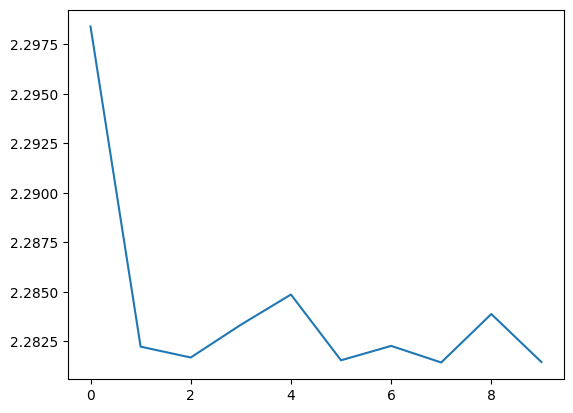

In [807]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [808]:
def split_loss(split):
    device = "mps"
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    x, y = x.to(device), y.to(device)
    model.eval()
    logits, _ = model(x)
    logits = logits[:, -1, :]
    loss = F.cross_entropy(logits, y)
    print(f"{split}: {loss.item()}")
    model.train()

In [809]:
split_loss('train')
split_loss('test')
split_loss('val')

train: 2.2829196453094482
test: 2.268447160720825
val: 2.2867777347564697


In [810]:
num_names = 1000
with open("rnn-generated.txt", 'a') as f:
    names = []
    for _ in range(num_names):
        names.append(sample_name(model, block_size, ctoi, itoc, "mps").lower())

    names.sort()
    f.write('\n'.join(names))

In [811]:
found = 0
with open("rnn-generated.txt", 'r') as f:
    lines = f.read()
    gen_names = lines.split('\n')
    for name in gen_names:
        if name in words:
            found += 1

print(f"There exists {found} many repeats in {num_names} num names")
print(f"Repeat rate is {found/num_names:.4f}")

        

There exists 49 many repeats in 1000 num names
Repeat rate is 0.0490
